# Hello DeepLens: Introduction to Lens Simulation

This notebook demonstrates the basic usage of DeepLens, a differentiable ray tracing framework for:
- Automated optical design
- End-to-end optics-network co-design
- Computational photography

References:
1. Xinge Yang, Qiang Fu and Wolfgang Heidrich, "Curriculum learning for ab initio deep learned refractive optics," Nature Communications 2024.
2. Congli Wang, Ni Chen, and Wolfgang Heidrich, "dO: A differentiable engine for Deep Lens design of computational imaging systems," IEEE TCI 2023.

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from deeplens import GeoLens
import torch
from torchvision.utils import make_grid, save_image

# Set plotting style
# plt.style.use('seaborn')
%matplotlib inline

## 1. Loading a Lens

We'll load the Canon EF 35mm f/2.0 lens as an example. This is a classic photographic lens design.

In [3]:
# Load the lens
lens = GeoLens(filename="./lenses/camera/ef35mm_f2.0.json")

# Print basic lens information
print(f"Lens focal length: {lens.foclen:.2f} mm")
print(f"Lens f-number: f/{lens.fnum:.2f}")
print(f"Lens field of view: {lens.hfov*2:.2f} degrees")
print(f"Sensor size: {lens.sensor_size[0]:.2f} x {lens.sensor_size[1]:.2f} mm")

Using CUDA: NVIDIA A100-SXM4-80GB
Lens focal length: 35.51 mm
Lens f-number: f/2.15
Lens field of view: 1.11 degrees
Sensor size: 30.55 x 30.55 mm


## 2. Lens Layout Visualization

Let's visualize the lens layout in different ways:

<Figure size 1500x800 with 0 Axes>

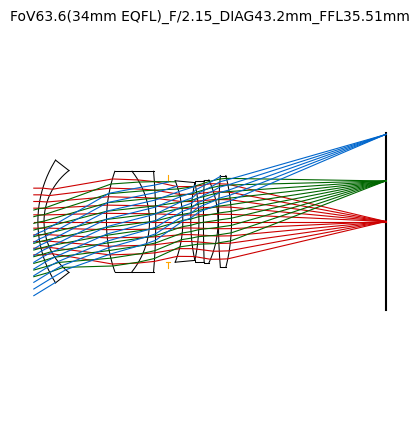

<Figure size 1500x800 with 0 Axes>

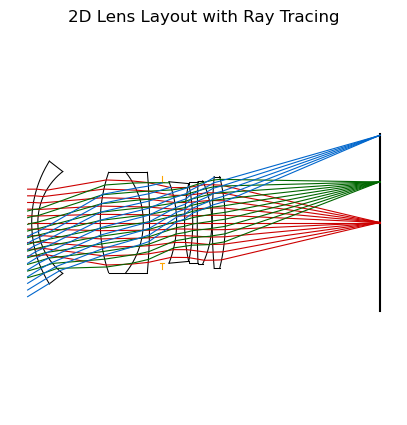

In [5]:
# Create a helper function for lens visualization without saving
def plot_lens_layout(lens, depth=float('inf'), entrance_pupil=True, zmx_format=True):
    from deeplens.geolens_utils import draw_setup_2d, draw_raytraces_2d
    import numpy as np
    from deeplens.optics.basics import WAVE_RGB
    
    num_rays = 11
    num_views = 3
    
    colors_list = ["#CC0000", "#006600", "#0066CC"]
    views = np.linspace(0, float(np.rad2deg(lens.hfov) * 0.99), num=num_views)
    ax, fig = draw_setup_2d(lens, zmx_format=zmx_format)

    for i, view in enumerate(views):
        if depth == float("inf"):
            ray = lens.sample_parallel_2D(
                fov=view,
                wvln=WAVE_RGB[2 - i],
                num_rays=num_rays,
                entrance_pupil=entrance_pupil,
                depth=-1.0,
            )
        else:
            ray = lens.sample_point_source_2D(
                fov=view,
                depth=depth,
                num_rays=num_rays,
                wvln=WAVE_RGB[2 - i],
                entrance_pupil=entrance_pupil,
            )

        _, ray_o_record = lens.trace2sensor(ray=ray, record=True)
        ax, fig = draw_raytraces_2d(
            ray_o_record, ax=ax, fig=fig, color=colors_list[i]
        )

    ax.axis("off")
    return fig, ax

# Draw the layout using our custom function
plt.figure(figsize=(15, 8))
fig, ax = plot_lens_layout(lens, depth=float('inf'), entrance_pupil=True, zmx_format=True)
plt.title('2D Lens Layout with Ray Tracing')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

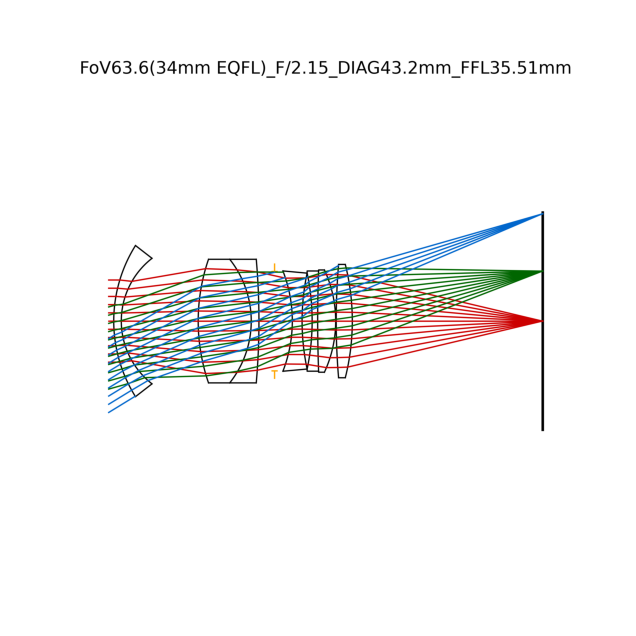

In [11]:
# 2.1 2D Layout with ray tracing
lens.draw_layout(filename="lens_layout.png", depth=float('inf'), entrance_pupil=True, zmx_format=True)


from PIL import Image
img = Image.open("lens_layout.png")
plt.figure(figsize=(15, 8))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()


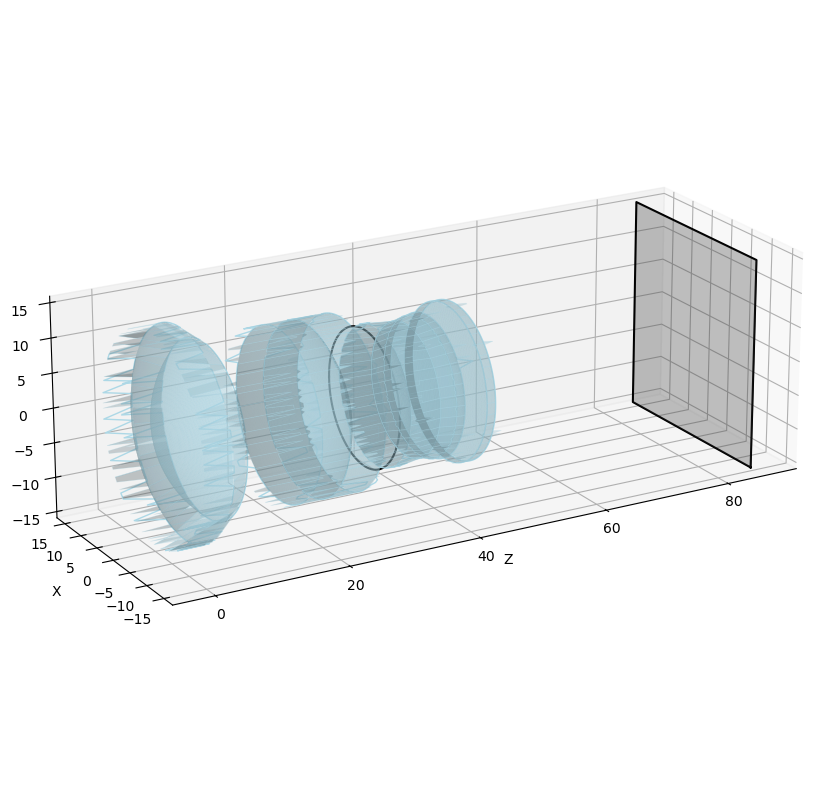

(<Figure size 1200x800 with 1 Axes>,
 <Axes3D: xlabel='Z', ylabel='X', zlabel='Y'>)

In [8]:
# 2.2 3D Layout visualization
lens.draw_layout_3d(filename="lens_layout3D.png", figsize=(12, 8), view_angle=30, show=True)

## 3. Optical Performance Analysis

/home/yz/DeepLens/deeplens/geolens.py:2499: RuntimeWarning: invalid value encountered in scalar divide
  xc, yc = x.sum() / ra_.sum(), y.sum() / ra_.sum()


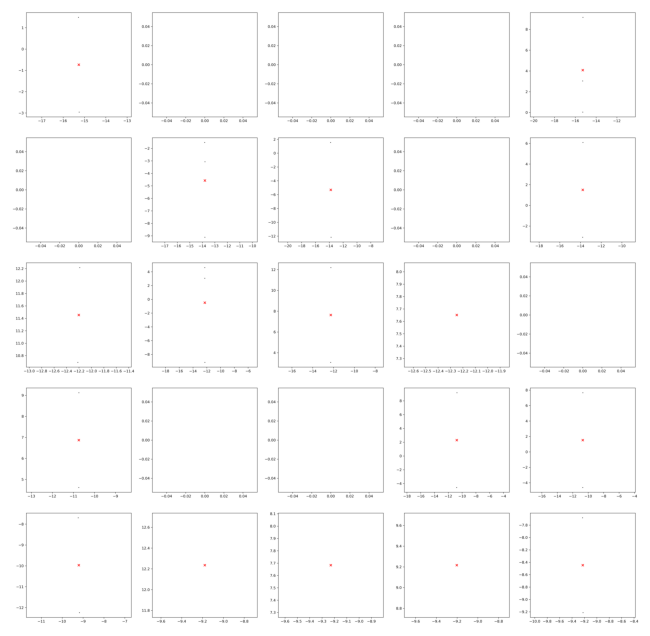

In [63]:
# 3.1 Spot Diagram
depth = -5000
save_name = f"./spot{-depth}mm.png"

lens.draw_spot_diagram(M=5, depth = depth)

img = Image.open(save_name)
plt.figure(figsize=(15, 8))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()

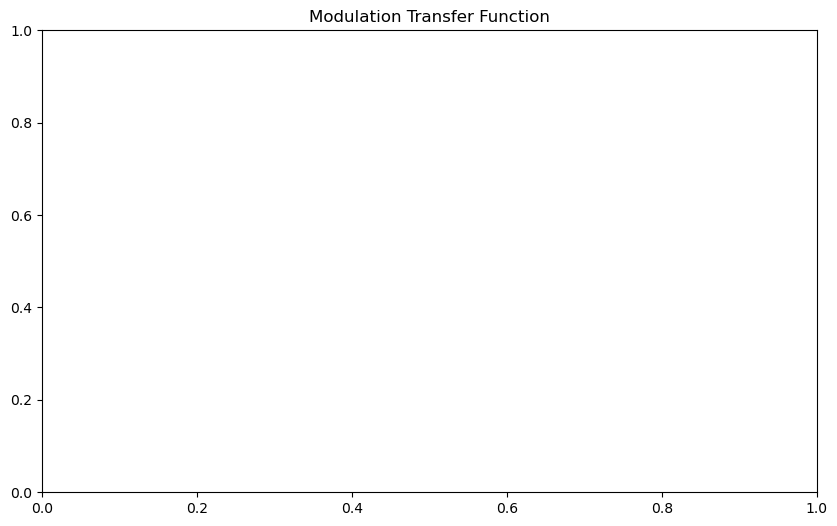

In [64]:
def draw_mtf_safe(lens, depth, relative_fov, max_attempts=3):
    """Try to draw MTF with progressively smaller FOV if needed."""
    for attempt in range(max_attempts):
        try:
            # Reduce FOV range on each attempt
            current_fov = [fov * (1 - 0.2*attempt) for fov in relative_fov]
            return lens.draw_mtf(
                depth=depth,
                relative_fov=current_fov,
                save_name=f"mtf_attempt_{attempt}.png"
            )
        except AssertionError as e:
            if attempt == max_attempts - 1:
                print(f"Failed after {max_attempts} attempts with reduced FOV.")
                raise
            else:
                print(f"Attempt {attempt+1} failed. Reducing FOV values...")

# Use the safe function
plt.figure(figsize=(10, 6))
draw_mtf_safe(lens, depth=depth, relative_fov=[0.0, 0.7, 1.0])
plt.title('Modulation Transfer Function')
plt.show()

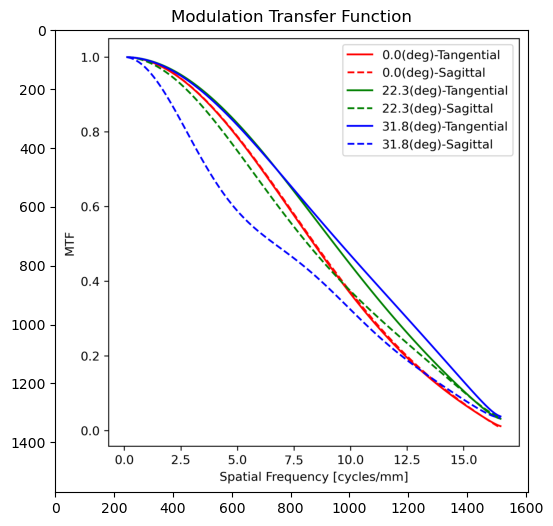

In [65]:
# 3.2 MTF (Modulation Transfer Function)

lens.draw_mtf(depth=depth, relative_fov=[0.0, 0.7, 1.0])

img = Image.open('mtf.png')
plt.figure(figsize=(10, 6))
plt.imshow(np.array(img))
plt.title('Modulation Transfer Function')
plt.show()

PSF radial has been saved to psf_radial.png


<Figure size 1200x800 with 0 Axes>

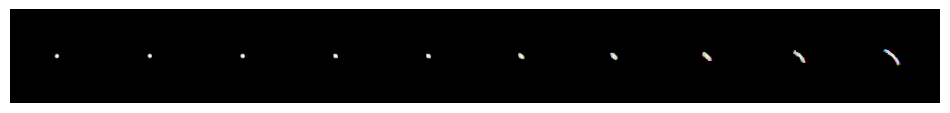

In [68]:
#!/usr/bin/env python3
"""
Fix for the DeepLens PSF radial function that uses 'center' instead of 'recenter'.
"""

def fixed_psf_radial(lens, M=3, depth=float('inf'), ks=101, log_scale=True, save_name="psf_radial.png"):
    """Modified version of draw_psf_radial that fixes the parameter mismatch.
    
    Args:
        lens: The lens object
        M: Number of field positions (default: 3)
        depth: Object depth (default: infinity)
        ks: Kernel size for PSF (default: 101)
        log_scale: Whether to use log scale (default: True)
        save_name: Filename to save the PSF image
    """
    import torch
    from torchvision.utils import make_grid, save_image
    from deeplens.optics.basics import EPSILON
    
    x = torch.linspace(0, 1, M).to(lens.device)
    y = torch.linspace(0, 1, M).to(lens.device)
    z = torch.full_like(x, depth)
    points = torch.stack((x, y, z), dim=-1)
    
    psfs = []
    for i in range(M):
        # Fix: Use recenter instead of center
        psf = lens.psf_rgb(points=points[i], ks=ks, recenter=True, spp=4096)
        psf /= psf.max()
        
        if log_scale:
            psf = torch.log(psf + EPSILON)
            psf = (psf - psf.min()) / (psf.max() - psf.min())
            
        psfs.append(psf)
    
    psf_grid = make_grid(psfs, nrow=M, padding=1, pad_value=0.0)
    save_image(psf_grid, save_name, normalize=True)
    
    print(f"PSF radial has been saved to {save_name}")
    return save_name

plt.figure(figsize=(12, 8))
fixed_psf_radial(lens, M=10, depth=depth, log_scale=True, save_name="psf_radial.png") 

img = Image.open('psf_radial.png')
plt.figure(figsize=(12, 8))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()


<Figure size 1200x800 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

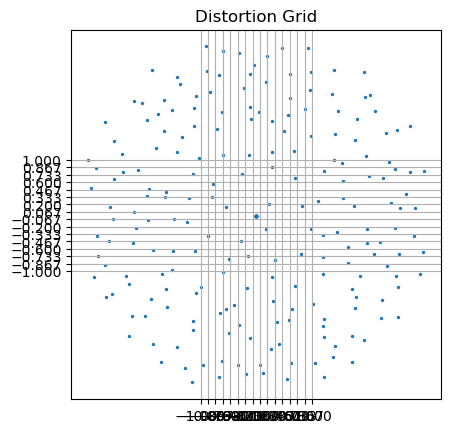

In [29]:
# 3.4 Distortion Analysis
plt.figure(figsize=(10, 10))
lens.draw_distortion(depth=depth, grid_size=16)
plt.title('Distortion Grid')
plt.show()

## 4. Image Rendering

Let's demonstrate the lens rendering capabilities using a sample image:

In [42]:
import cv2 as cv

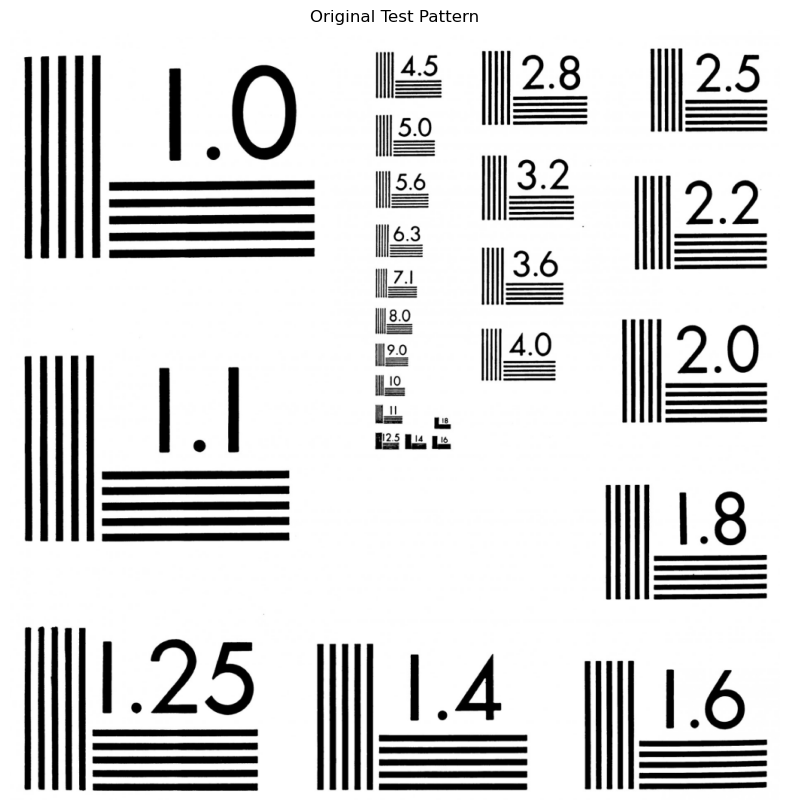

In [70]:

img = cv.cvtColor(cv.imread("./datasets/IQ/img1.png"), cv.COLOR_BGR2RGB)
img = torch.from_numpy(img).float() / 255.0  # Normalize to [0,1]
img = img.permute(2, 0, 1).unsqueeze(0)  # Convert to [B,C,H,W] format
sample_img = img


# Display original image
plt.figure(figsize=(10, 10))
plt.imshow(sample_img[0].permute(1, 2, 0))
plt.title('Original Test Pattern')
plt.axis('off')
plt.show()

In [76]:
# 4.2 Render image through the lens
# Render at different depths
# depths = [-1000, -2000, -5000]  # mm

depths = np.linspace(-10000, -1000, 5)

plt.figure(figsize=(15, 5))
for i, depth in enumerate(depths):
    # Move sample_img to the same device as lens
    sample_img_device = sample_img.to(lens.device)
    rendered_img = lens.render(sample_img_device, depth=depth)
    
    plt.subplot(1, len(depths), i+1)
    plt.imshow(rendered_img[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f'Rendered at {depth}mm')
    plt.axis('off')

plt.tight_layout()
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## 5. Advanced Analysis

Let's look at some additional lens characteristics:

In [38]:
# 5.1 Field Curvature
lens.field_curvature() # seems not implemented

In [39]:
# 5.2 RMS Spot Size Analysis
plt.figure(figsize=(10, 6))
lens.analysis_rms(depth=float('inf'))

RMS average error (chief ray): center 0.018 mm, middle 0.015 mm, off-axis 0.05 mm
RMS maximum radius (chief ray): center 0.038 mm, middle 0.027 mm, off-axis 0.315 mm


## 6. Conclusion

This notebook has demonstrated the key capabilities of DeepLens:
1. Loading and visualizing lens designs
2. Analyzing optical performance (MTF, PSF, Distortion)
3. Rendering images through the lens
4. Advanced optical analysis

DeepLens provides a comprehensive set of tools for optical design and analysis, making it valuable for both educational and research purposes in computational imaging.